In [1]:
import numpy as np
from PIL import Image
import os
import math
import matplotlib.pyplot as plt

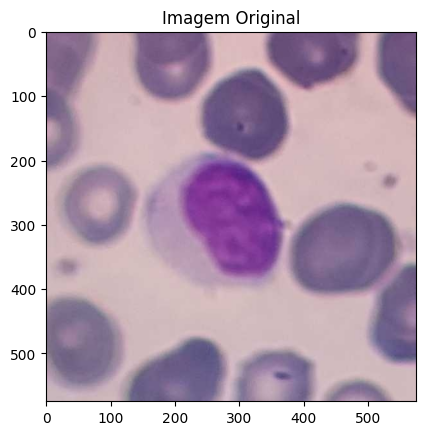

Dimensões da imagem: (575, 575, 3)


In [7]:
# imagem da pasta 'Lymphocyte'
caminho_imagem = 'Train/Lymphocyte/95-5-4-1_5_1.jpg'
# Abre a imagem
img_pil = Image.open(caminho_imagem) 

# Converte para um array Numpy
img_array = np.array(img_pil)

plt.imshow(img_array)
plt.title("Imagem Original")
plt.show()

# dimensões
print(f"Dimensões da imagem: {img_array.shape}")

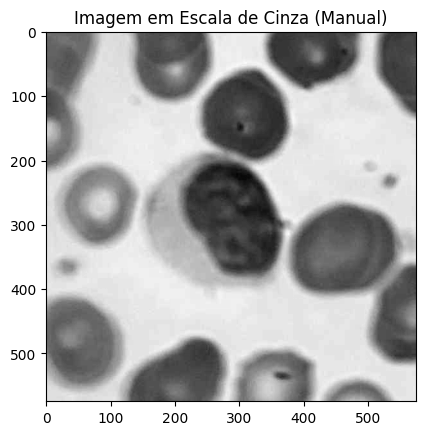

In [3]:
# Pega as dimensões
altura, largura, _ = img_array.shape

# Cria uma matriz "vazia" (cheia de zeros) para a imagem em escala de cinza
# Ela terá as mesmas altura e largura, mas apenas 1 canal
img_cinza = np.zeros((altura, largura), dtype=np.uint8)

# Loop "pixel a pixel" (manipulação direta)
for i in range(altura):
    for j in range(largura):
        # Pega os valores R, G, B do pixel (i, j)
        r = img_array[i, j, 0]
        g = img_array[i, j, 1]
        b = img_array[i, j, 2]

        # Aplica a fórmula de conversão
        valor_cinza = (0.299 * r) + (0.587 * g) + (0.114 * b)

        # Salva o resultado na nossa nova imagem
        img_cinza[i, j] = int(valor_cinza)

plt.imshow(img_cinza, cmap='gray')
plt.title("Imagem em Escala de Cinza (Manual)")
plt.show()

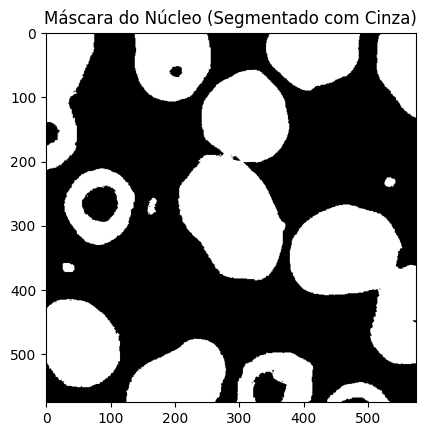

In [12]:
mascara_nucleo = np.zeros((altura, largura), dtype=np.uint8)

# Define nosso limite. 0 é preto, 255 é branco.
# Queremos pixels "escuros". 
limite_cinza = 150 

# Loop "pixel a pixel"
for i in range(altura):
    for j in range(largura):
        # Pega o valor do pixel na imagem EM CINZA
        valor_pixel_cinza = img_cinza[i, j]
        
        # Condição: Se o pixel for mais escuro que o nosso limite
        if valor_pixel_cinza < limite_cinza:
            mascara_nucleo[i, j] = 255 # Marca como "núcleo" (branco)

plt.imshow(mascara_nucleo, cmap='gray')
plt.title("Máscara do Núcleo (Segmentado com Cinza)")
plt.show()

In [14]:
features_da_imagem = []

# --- calcula a área ---
area_nucleo = 0
for i in range(altura):
    for j in range(largura):
        if mascara_nucleo[i, j] == 255:
            area_nucleo += 1

print(f"Característica [Área do Núcleo]: {area_nucleo} pixels")

features_da_imagem.append(area_nucleo)

print(f"Lista de características até agora: {features_da_imagem}")

Característica [Área do Núcleo]: 142889 pixels
Lista de características até agora: [142889]


In [15]:
soma_R = 0
soma_G = 0
soma_B = 0
# A contagem de pixels já temos, é a 'area_nucleo'

for i in range(altura):
    for j in range(largura):
        # Se este pixel PERTENCE ao núcleo...
        if mascara_nucleo[i, j] == 255:
            # ...pegue sua cor na imagem original
            soma_R += img_array[i, j, 0]
            soma_G += img_array[i, j, 1]
            soma_B += img_array[i, j, 2]

# Calcula a média (evita divisão por zero se a área for 0)
if area_nucleo > 0:
    media_R = soma_R / area_nucleo
    media_G = soma_G / area_nucleo
    media_B = soma_B / area_nucleo
else:
    media_R, media_G, media_B = 0, 0, 0

print(f"Característica [Média R]: {media_R:.2f}")
print(f"Característica [Média G]: {media_G:.2f}")
print(f"Característica [Média B]: {media_B:.2f}")

features_da_imagem.append(media_R)
features_da_imagem.append(media_G)
features_da_imagem.append(media_B)

Característica [Média R]: 125.81
Característica [Média G]: 98.47
Característica [Média B]: 142.14


Calcula a Média de Cinza (só do núcleo)

In [16]:
soma_cinza = 0
for i in range(altura):
    for j in range(largura):
        if mascara_nucleo[i, j] == 255:
            soma_cinza += img_cinza[i, j]

media_cinza = soma_cinza / area_nucleo if area_nucleo > 0 else 0

Calcula o Desvio Padrão

In [17]:
soma_diferencas_quadradas = 0
for i in range(altura):
    for j in range(largura):
        if mascara_nucleo[i, j] == 255:
            diferenca = img_cinza[i, j] - media_cinza
            soma_diferencas_quadradas += (diferenca ** 2)

if area_nucleo > 0:
    variancia = soma_diferencas_quadradas / area_nucleo
    desvio_padrao = math.sqrt(variancia)
else:
    desvio_padrao = 0

print(f"Característica [Textura/Desvio Padrão]: {desvio_padrao:.2f}")
features_da_imagem.append(desvio_padrao)

Característica [Textura/Desvio Padrão]: 17.94


In [ ]:
dataset_features = []

# Cabeçalho para o arquivo CSV
cabecalho = "dataset,classe,nome_arquivo,area_nucleo,media_R,media_G,media_B,desvio_padrao_textura"
dataset_features.append(cabecalho)

# Lista das pastas principais a processar
pastas_principais = ['Train', 'TestA', 'TestB']

# Caminho base das pastas 'Train', 'TestA', 'TestB'
caminho_base = '.' 

print("Iniciando extração de características...")

# 1. Loop pelas pastas principais (Train, TestA, TestB)
for nome_pasta_principal in pastas_principais:
    pasta_principal = os.path.join(caminho_base, nome_pasta_principal)
    
    # Verifica se a pasta principal existe
    if not os.path.isdir(pasta_principal):
        print(f"Aviso: Pasta '{pasta_principal}' não encontrada. Pulando.")
        continue

    print(f"\n--- Processando pasta: {nome_pasta_principal} ---")

    # 2. Loop pelas sub-pastas 
    for nome_classe in os.listdir(pasta_principal):
        pasta_classe = os.path.join(pasta_principal, nome_classe)
        
        # Garante que é um diretório (pasta)
        if not os.path.isdir(pasta_classe):
            continue
            
        print(f"  Processando classe: {nome_classe}")
        
        # 3. Loop por cada imagem dentro da pasta da classe
        for nome_arquivo in os.listdir(pasta_classe):
            caminho_completo = os.path.join(pasta_classe, nome_arquivo)
            
            # Garante que é um arquivo de imagem
            if not (nome_arquivo.endswith('.jpg') or nome_arquivo.endswith('.png')):
                continue
                
            try:             
                # 1. Carregar Imagem
                img_pil = Image.open(caminho_completo)
                img_array = np.array(img_pil)
                altura, largura, _ = img_array.shape

                # 2. Pré-processamento (Cinza)
                img_cinza = np.zeros((altura, largura), dtype=np.uint8)
                for i in range(altura):
                    for j in range(largura):
                        r, g, b = img_array[i, j]
                        img_cinza[i, j] = int((0.299 * r) + (0.587 * g) + (0.114 * b))

                # ==========================================================                
                # Método de segmentação RGB pelo de Escala de Cinza
                # ==========================================================
                
                # 3. Segmentação (Máscara do Núcleo com Escala de Cinza)
                mascara_nucleo = np.zeros((altura, largura), dtype=np.uint8)
                
                # Usando o valor validado no teste
                limite_cinza = 150 

                for i in range(altura):
                    for j in range(largura):
                        # Pega o valor do pixel na imagem EM CINZA
                        valor_pixel_cinza = img_cinza[i, j]
                        
                        # Condição: Se o pixel for mais escuro que o nosso limite
                        if valor_pixel_cinza < limite_cinza:
                            mascara_nucleo[i, j] = 255 # Marca como "núcleo" (branco)               

                # 4. Extração de Características
                area_nucleo = 0
                soma_R, soma_G, soma_B, soma_cinza = 0, 0, 0, 0

                for i in range(altura):
                    for j in range(largura):
                        if mascara_nucleo[i, j] == 255:
                            area_nucleo += 1
                            soma_R += img_array[i, j, 0]
                            soma_G += img_array[i, j, 1]
                            soma_B += img_array[i, j, 2]
                            soma_cinza += img_cinza[i, j]

                # Pula a imagem se a segmentação falhou
                if area_nucleo == 0:
                    print(f"    ! Aviso: Nenhum núcleo encontrado em {nome_arquivo}. Pulando.")
                    continue 

                media_R = soma_R / area_nucleo
                media_G = soma_G / area_nucleo
                media_B = soma_B / area_nucleo
                media_cinza = soma_cinza / area_nucleo

                soma_diferencas_quadradas = 0
                for i in range(altura):
                    for j in range(largura):
                        if mascara_nucleo[i, j] == 255:
                            soma_diferencas_quadradas += (img_cinza[i, j] - media_cinza) ** 2
                
                # Adiciona verificação para evitar raiz de número negativo (muito raro, mas seguro)
                if soma_diferencas_quadradas < 0: soma_diferencas_quadradas = 0
                
                desvio_padrao = math.sqrt(soma_diferencas_quadradas / area_nucleo)
                
                # ==========================================================
                # FIM DO PROCESSO DA IMAGEM
                # ==========================================================
                
                # Salva a linha de features com os novos dados (dataset e classe)
                linha = f"{nome_pasta_principal},{nome_classe},{nome_arquivo},{area_nucleo},{media_R:.2f},{media_G:.2f},{media_B:.2f},{desvio_padrao:.2f}"
                dataset_features.append(linha)

            except Exception as e:
                print(f"    ! Erro ao processar o arquivo {nome_arquivo}: {e}")

# 5. Salva tudo em um único arquivo CSV
nome_arquivo_saida = "features_completas.csv"
with open(nome_arquivo_saida, "w") as f:
    for linha in dataset_features:
        f.write(linha + "\n")

print(f"\nProcesso concluído! Características salvas em '{extracao_final}'")

Iniciando extração de características...

--- Processando pasta: Train ---
  Processando classe: Basophil
  Processando classe: Eosinophil
